In [ ]:
!ls
!wget -c https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar
get_ipython().system_raw("unrar x PH2Dataset.rar")

In [194]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

In [195]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [196]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [197]:
len(lesions)

200

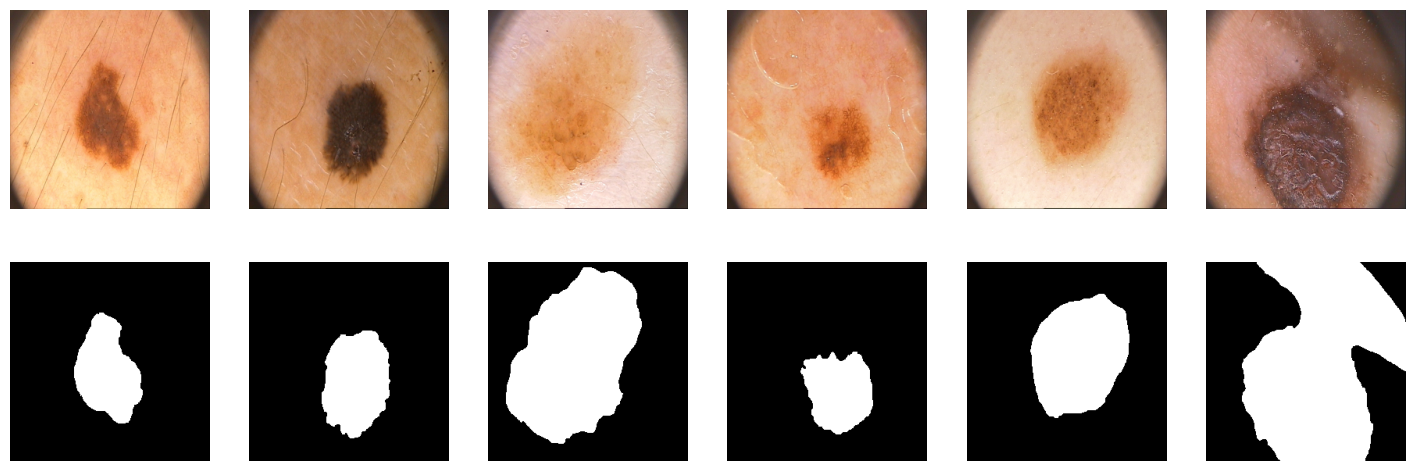

In [198]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i], cmap='gray')
plt.show();

In [199]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [200]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [201]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [421]:
!nvidia-smi

Sun Nov 27 14:53:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.43.04    Driver Version: 515.43.04    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-DGXS...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   53C    P0   250W / 300W |  15428MiB / 16384MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-DGXS...  On   | 00000000:08:00.0 Off |                    0 |
| N/A   

In [422]:
%env NVIDIA_VISIBLE_DEVICES=1
%env CUDA_VISIBLE_DEVICES=2

!echo $NVIDIA_VISIBLE_DEVICES
!echo $CUDA_VISIBLE_DEVICES

env: NVIDIA_VISIBLE_DEVICES=1
env: CUDA_VISIBLE_DEVICES=2
1
2


In [423]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [15]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        # 256 -> 128
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        
        # 128 -> 64
        
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        
        # 64 -> 32
        
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        
        # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        # decoder (upsampling)
            
        # 16 -> 32
        self.upsample = nn.MaxUnpool2d(2, stride=2)
        
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
            
        # 32 -> 64
            
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
            
        # 64 -> 128
            
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
            
        # 128 -> 256
            
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1)
        )

    def forward(self, x):
        # encoder
        e0, indices_0 = self.pool(self.enc_conv0(x))
        e1, indices_1 = self.pool(self.enc_conv1(e0))
        e2, indices_2 = self.pool(self.enc_conv2(e1))
        e3, indices_3 = self.pool(self.enc_conv3(e2))

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.dec_conv0(self.upsample(b, indices_3))
        d1 = self.dec_conv1(self.upsample(d0, indices_2))
        d2 = self.dec_conv2(self.upsample(d1, indices_1))
        d3 = self.dec_conv3(self.upsample(d2, indices_0))  # no activation
        return d3

In [16]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded

In [18]:
from torch.nn.functional import relu

def bce_loss(y_real, y_pred):
    
    y_real = y_real.squeeze(1)
    y_pred = y_pred.squeeze(1)
    
    res = torch.mean(relu(y_pred) - y_pred * y_real + torch.log(1. + torch.exp(-torch.abs(y_pred))))
    
    return res

In [303]:
from skimage.segmentation import find_boundaries
from scipy.ndimage import distance_transform_edt as eucl_dist

def normalize(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())

def compute_sdm(sample_gt):
    
    pos_mask = sample_gt
    neg_mask = 1 - pos_mask
    
    pos_dist = eucl_dist(pos_mask)
    neg_dist = eucl_dist(neg_mask)
    bound = find_boundaries(pos_mask.cpu().numpy(), mode='inner').astype(np.uint8)
    
    sdm = normalize(eucl_dist(neg_mask)) - normalize(eucl_dist(pos_mask))
    sdm[seg==1] = 0
    
    return torch.tensor(sdm)

In [478]:
def train(model, opt, scheduler, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))
    
    if hasattr(loss_fn, 'func') and loss_fn.func.__name__ == 'boundary_loss':
        
        with torch.no_grad():
            sdm_batches = []

            for _, Y_batch in data_tr:
                sdm_batch = []
                for sample in Y_batch:
                    sdm = compute_sdm(sample)
                    sdm_batch.append(sdm)

                sdm_batches.append(torch.stack(sdm_batch))
    
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        
        for idx, (X_batch, Y_batch) in enumerate(data_tr):
            # data to device
            X_batch = X_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch).cpu()
            
            if hasattr(loss_fn, 'func') and loss_fn.func.__name__ == 'boundary_loss':
                l = idx * X_batch.shape[0]
                r = l + X_batch.shape[0]
                
                loss = loss_fn(Y_batch, Y_pred, sdm=sdm_batches[l:r])
            else:
                loss = loss_fn(Y_batch, Y_pred) # forward-pass
            
            loss.backward() # backward-pass
            opt.step() # update weights
            scheduler.step()

            # calculate loss to show the user
            avg_loss += loss
            
        toc = time()
        avg_loss /= len(data_tr)
        print('loss: %f' % avg_loss)

        # show intermediate results
        model.eval() # testing mode
        Y_hat = model(X_val.to(device)).detach().cpu() # detach and put into cpu

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

In [479]:
sigmoid = torch.sigmoid

def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        
        X_batch = X_batch.to(device)
        
        Y_pred = model(X_batch).detach().cpu()
        
        scores += metric(sigmoid(Y_pred) > 0.5, Y_label.long()).mean().item()

    return scores/len(data)

In [480]:
import gc

torch.cuda.empty_cache()
gc.collect()

2069

In [481]:
model = SegNet().to(device)

In [482]:
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

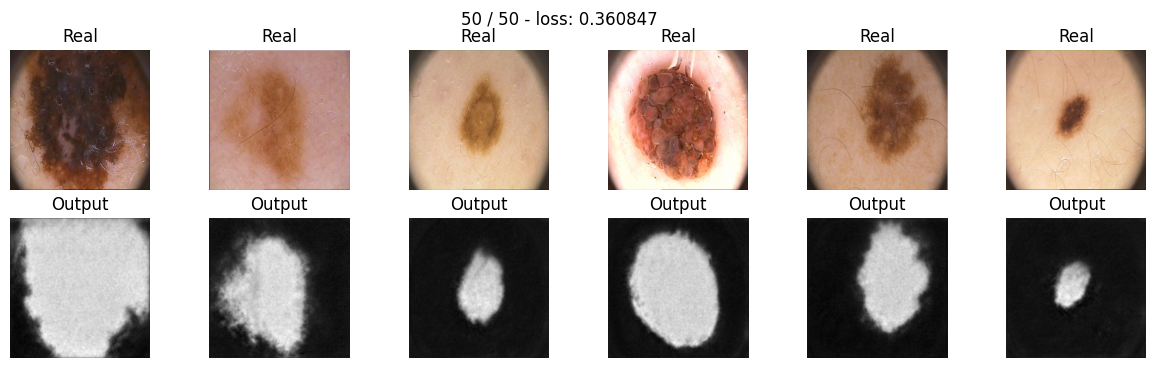

In [483]:
max_epochs = 50
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)
scheduler = CosineAnnealingLR(optimizer, T_max=max_epochs//5, eta_min=1e-5)

train(model, optimizer, scheduler, bce_loss, max_epochs, data_tr, data_val)

In [484]:
score_model(model, iou_pytorch, data_val)

0.6940000057220459